<a href="https://colab.research.google.com/github/hayashiyus/First-steps-towards-Deep-Learning/blob/main/16_Probability_theory.ipynb" target="_parent">
 <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
#@title install packages
!pip install mplcyberpunk
!pip install watermark

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import mplcyberpunk

In [3]:
import re
import os
import PIL
import copy
import random
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <8080486D-E510-3000-AA6A-F3AD49ACC172> /Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/image.so
  Expected in:     <EBBC8B94-2FD8-3694-B341-8B60B237B8E9> /Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [4]:
import warnings
warnings.simplefilter('ignore')

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### **0.　準備**
ドロップアウト，重み減衰を実装するために，ベースとなるCNNモデルを準備します．

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <8080486D-E510-3000-AA6A-F3AD49ACC172> /Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/image.so
  Expected in:     <EBBC8B94-2FD8-3694-B341-8B60B237B8E9> /Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-package

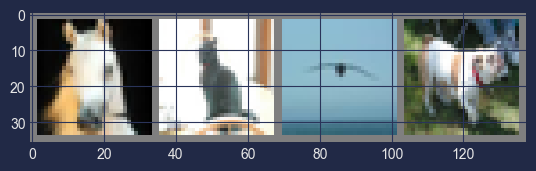

horse cat   bird  dog  


In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
plt.style.use("cyberpunk")
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
## test the model with 1 batch
model = CNN()
for images, labels in trainloader:
    print("batch size:", images.shape)
    y_hat = model(images)
    print(y_hat.shape)
    break

/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <8080486D-E510-3000-AA6A-F3AD49ACC172> /Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/image.so
  Expected in:     <EBBC8B94-2FD8-3694-B341-8B60B237B8E9> /Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-package

batch size: torch.Size([4, 3, 32, 32])
torch.Size([4, 10])


### **1.　ドロップアウト**

##### **問1：ドロップアウトの実装**
MNISTを学習するCNNモデルを作成し，学習時にL2正則化を適用してください．

In [10]:
class CNN_with_Dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # Define proportion or neurons to dropout
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [11]:
## test the model with 1 batch
model = CNN_with_Dropout()
for images, labels in trainloader:
    print("batch size:", images.shape)
    y_hat = model(images)
    print(y_hat.shape)
    break

/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <8080486D-E510-3000-AA6A-F3AD49ACC172> /Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/image.so
  Expected in:     <EBBC8B94-2FD8-3694-B341-8B60B237B8E9> /Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-package

batch size: torch.Size([4, 3, 32, 32])
torch.Size([4, 10])


In [13]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
# エポック数
epochs = 10
# 学習率
learning_rate = 0.0001

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
for epoch in range(epochs):
    # モデルの訓練
    model.train()
    temp_train_loss = []
    temp_train_acc = []
    for i, (images, labels) in enumerate(trainloader):
        labels_pred = model(images)
        loss = criterion(labels_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        temp_train_loss.append(loss.detach())
        temp_acc = get_accuracy(labels_pred, labels, batch_size)
        temp_train_acc.append(temp_acc) 
    train_loss.append(np.average(temp_train_loss))    # 訓練誤差をリストに保存
    train_accuracy.append(np.average(temp_train_acc)) # 予測性能をリストに保存
    # モデルの評価
    model.eval()
    temp_test_loss = []
    temp_test_acc = []
    for i, (images, labels) in enumerate(testloader):    
        labels_pred = model(images)
        loss = criterion(labels_pred, labels)
        temp_test_loss.append(loss.detach())
        temp_acc = get_accuracy(labels_pred, labels, batch_size)
        temp_test_acc.append(temp_acc) 
    test_loss.append(np.average(temp_test_loss))    # 訓練誤差をリストに保存
    test_accuracy.append(np.average(temp_test_acc)) # 訓練誤差をリストに保存

/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <8080486D-E510-3000-AA6A-F3AD49ACC172> /Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/image.so
  Expected in:     <EBBC8B94-2FD8-3694-B341-8B60B237B8E9> /Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-package

### **2.　重み減衰**

##### **問2：L2正則化の実装**
MNISTを学習するCNNモデルを作成し，学習時にL2正則化を適用してください．

##### **例1**

In [ ]:
## test the model with 1 batch
model = CNN_with_Dropout()
for images, labels in trainloader:
    print("batch size:", images.shape)
    y_hat = model(images)
    print(y_hat.shape)
    break

In [ ]:
# エポック数
epochs = 10
# 学習率
learning_rate = 0.0001

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.001)

train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
for epoch in range(epochs):
    # モデルの訓練
    model.train()
    temp_train_loss = []
    temp_train_acc = []
    for i, (images, labels) in enumerate(trainloader):
        labels_pred = model(images)
        loss = criterion(labels_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        temp_train_loss.append(loss.detach())
        temp_acc = get_accuracy(labels_pred, labels, batch_size)
        temp_train_acc.append(temp_acc) 
    train_loss.append(np.average(temp_train_loss))    # 訓練誤差をリストに保存
    train_accuracy.append(np.average(temp_train_acc)) # 予測性能をリストに保存
    # モデルの評価
    model.eval()
    temp_test_loss = []
    temp_test_acc = []
    for i, (images, labels) in enumerate(testloader):    
        labels_pred = model(images)
        loss = criterion(labels_pred, labels)
        temp_test_loss.append(loss.detach())
        temp_acc = get_accuracy(labels_pred, labels, batch_size)
        temp_test_acc.append(temp_acc) 
    test_loss.append(np.average(temp_test_loss))    # 訓練誤差をリストに保存
    test_accuracy.append(np.average(temp_test_acc)) # 訓練誤差をリストに保存

In [ ]:
%load_ext watermark
%watermark --iversions